# ML Water Explore

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score as metric_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from scipy.stats import skew, boxcox_normmax, chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer, PowerTransformer

## Setting Key Values

In [2]:
SEED = 1
# Train X
DATA_PATH = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
# Train y
DATA_PATH2 = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
# Test X
DATA_PATH3 = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'
TARGET_VARIABLE = 'status_group'
SPLITS = 5
MAX_ITER = 1000
#For metric, import the required library as metric_scorer
METRIC = 'accuracy'

## Data Reading and Exploration
Here we read the data, print its first rows and describe its contents

In [3]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])

X_train = read_data(DATA_PATH)
y_train = read_data(DATA_PATH2)
X_test = read_data(DATA_PATH3)

X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
data = X_train.merge(y_train, on = ['id'])

data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


We review the data types for each column

In [6]:
data.dtypes

id                         int64
amount_tsh                object
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

We check if there is any missing data

In [7]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(data)

,Total,Percent
scheme_name,28166,0.474175
scheme_management,3877,0.065269
installer,3655,0.061532
funder,3635,0.061195
public_meeting,3334,0.056128
permit,3056,0.051448
subvillage,371,0.006246
ward,0,0.000000
lga,0,0.000000
district_code,0,0.000000


We drop unnecessary columns

In [109]:
def drop_columns(df, cols):
    df.drop(df[cols], axis=1, inplace = True)
    return df

#data = drop_columns(data, ['instant','casual'])
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1


## Converting Columns to their true categorical type
Now fixing the data types of numerical columns that are actually categorical

In [8]:
data = pd.concat([
        data.select_dtypes([], ['object']),
        data.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex_axis(data.columns, axis=1)
data.dtypes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  after removing the cwd from sys.path.


id                          int64
amount_tsh               category
date_recorded            category
funder                   category
gps_height                  int64
installer                category
longitude                 float64
latitude                  float64
wpt_name                 category
num_private                 int64
basin                    category
subvillage               category
region                   category
region_code                 int64
district_code               int64
lga                      category
ward                     category
population                  int64
public_meeting           category
recorded_by              category
scheme_management        category
scheme_name              category
permit                   category
construction_year           int64
extraction_type          category
extraction_type_group    category
extraction_type_class    category
management               category
management_group         category
payment       

## Plotting the target variable

In [23]:
data['status_group'].unique()

[functional, non functional, functional needs repair]
Categories (3, object): [functional, non functional, functional needs repair]

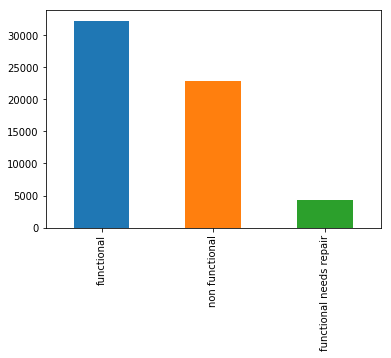

In [25]:
data['status_group'].value_counts().plot(kind='bar')

## Explore distribution of target variable for missing values

[Text(0, 0.5, 'Percent')]

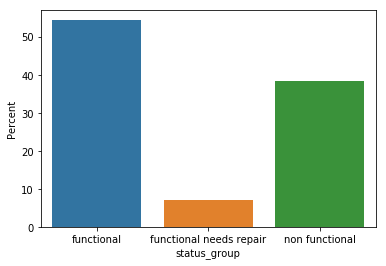

In [30]:
ax = sns.barplot(x="status_group", y="longitude", data=data, estimator=lambda x: len(x) / len(data) * 100)
ax.set(ylabel="Percent")

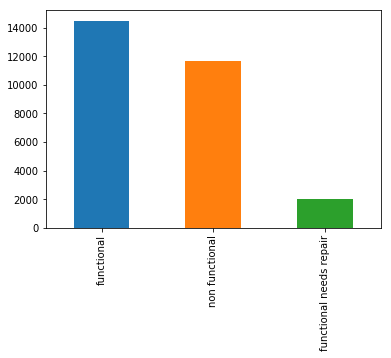

In [27]:
data['status_group'][pd.isnull(data['scheme_name'])].value_counts().plot(kind='bar')

## Data Correlation
Now we will look at correlation, both numerical and categorical and plot them

In [26]:
def numerical_correlated(df, threshold=0.9):
    corr_matrix = np.absolute(df.select_dtypes(include=[np.number]).corr(method='spearman')).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr_matrix

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

def categorical_correlated(df, threshold=0.9):
    columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                cell = cramers_v(df[columns[i]], df[columns[j]])
                corr[columns[i]][columns[j]] = cell
                corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    upper = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr


def correlated(df, threshold=0.9):
    return (categorical_correlated(df, threshold), numerical_correlated(df, threshold))

correlated_cols = correlated(data, 0.7)

if(len(correlated_cols[0][0]) + len(correlated_cols[1][0]) > 0):
    print('The following columns are correlated: ' + str(correlated_cols[0][0] + correlated_cols[1][0]))
else:
    print('No correlated columns for the selected threshold')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

Plot the categorical columns

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[0][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

Plot the numerical columns

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[1][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

## Adding Registered Customers Lag

In [117]:
#def add_lag(df, cols, lags):
#     new_cols = []
#     for col in cols:
#         for lag in lags:
#             new_col = df['registered'].shift(-lag).rename(str(col) + '_' + str(lag))
#             new_cols.append(new_col) 
#     df = pd.concat([df, new_cols], axis = 1)
#     return df

# data = add_lag(data, ['registered'], [1,24])
# holdout = add_lag(data, ['registered'], [1,24])

# registered_1 = data['registered'].shift(-1).rename("registered_1")
# registered_24 = data['registered'].shift(-24).rename("registered_24")
# data = pd.concat([data, registered_1, registered_24], axis = 1)

# registered_1 = holdout['registered'].shift(-1).rename("registered_1")
# registered_24 = holdout['registered'].shift(-24).rename("registered_24")
# holdout = pd.concat([holdout, registered_1, registered_24], axis = 1)

# data.head()

## Dropping Selected Correlated Columns

In [118]:
data = drop_columns(data, ['season', 'workingday', 'temp', 'registered'])
holdout = drop_columns(holdout, ['season', 'workingday', 'temp', 'registered'])
data.head()

,dteday,yr,mnth,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,registered_24
0,2011-01-01,0,1,0,0,6,1,0.2879,0.81,0.0,16,12.9
1,2011-01-01,0,1,1,0,6,1,0.2727,0.80,0.0,40,31.9
2,2011-01-01,0,1,2,0,6,1,0.2727,0.80,0.0,32,26.9
3,2011-01-01,0,1,3,0,6,1,0.2879,0.75,0.0,13,9.9
4,2011-01-01,0,1,4,0,6,1,0.2879,0.75,0.0,1,0.9


## Extracting Day Variable

In [119]:
def extract_day(df):
    df['day'] = df['dteday'].dt.day
    df = convert_to_category(df, ['day'])
    df = drop_columns(df, ['dteday'])
    return df

data = extract_day(data)
holdout = extract_day(holdout)
data.head()

,yr,mnth,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,registered_24,day
0,0,1,0,0,6,1,0.2879,0.81,0.0,16,12.9,1
1,0,1,1,0,6,1,0.2727,0.80,0.0,40,31.9,1
2,0,1,2,0,6,1,0.2727,0.80,0.0,32,26.9,1
3,0,1,3,0,6,1,0.2879,0.75,0.0,13,9.9,1
4,0,1,4,0,6,1,0.2879,0.75,0.0,1,0.9,1


## Fixing Data Skewness and Standardizing
Now we will fix skewness if present and standardize numerical features

In [120]:
pt = PowerTransformer(method='yeo-johnson', standardize = True).fit(data.iloc[:,6:9])
data.iloc[:,6:9] = pt.transform(data.iloc[:,6:9])
holdout.iloc[:,6:9] = pt.transform(holdout.iloc[:,6:9])
data.head()

,yr,mnth,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,registered_24,day
0,0,1,0,0,6,1,-1.147773,0.945987,-1.781706,16,12.9,1
1,0,1,1,0,6,1,-1.225548,0.893007,-1.781706,40,31.9,1
2,0,1,2,0,6,1,-1.225548,0.893007,-1.781706,32,26.9,1
3,0,1,3,0,6,1,-1.147773,0.629503,-1.781706,13,9.9,1
4,0,1,4,0,6,1,-1.147773,0.629503,-1.781706,1,0.9,1


## Outlier Winsorizing
Now we will winsorize outliers

In [121]:
def winsorize_data(df, cols):
    df[cols.columns] = winsorize(df[cols.columns], limits = [0.01, 0.01])
    return df

data = winsorize_data(data, data.iloc[:,np.r_[:,6:9]])

data.describe()

,atemp,hum,windspeed,cnt,registered_24
count,15211.000000,15211.000000,15211.000000,15211.000000,15211.000000
mean,-0.000480,0.003864,-0.007738,185.225232,148.709066
std,0.988445,0.991477,0.981681,177.918222,146.852050
min,-1.889375,-1.889375,-1.781706,1.000000,-0.100000
25%,-0.911043,-0.801054,-0.680979,39.000000,33.000000
50%,0.014506,-0.044433,0.116538,138.000000,111.000000
75%,0.742192,0.787325,0.588581,275.000000,213.000000
max,2.021428,1.969779,2.021428,977.000000,886.000000


## Underrepresented Features
Now we will see underrepresented features

In [122]:
def under_represented_features(df, threshold = 0.85):
    under_rep = []
    for column in df.select_dtypes(include=["object"]):
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)
    return under_rep

under_represented = under_represented_features(data)

if not under_represented:
    print('No underrepresented features')
else:
    print(str(under_represented) + ' are underrepresented, removing them')
    data = drop_columns(data, [x for x in under_represented if data.columns[x]!= TARGET_VARIABLE])
    data.head()

No underrepresented features


## Cross Validation
Now we will perform cross validation

In [123]:
def cv_evaluate(df, splits = 10, model = None, transformers = None, final = False, skipGrid = True):
    kfolds = KFold(n_splits = splits, shuffle=True, random_state = SEED)
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state= SEED)
    if model is None:
        model = LinearRegression()
        if transformers is None:
            model = make_pipeline(model)
        else:
            model = make_pipeline(model)
            for ind,i in enumerate(transformers):
                model.steps.insert(ind,[str(ind+1),i])
    
    if final:
        if skipGrid:
            model = LinearRegression()
            model = make_pipeline(model)
            for ind,i in enumerate(transformers):
                model.steps.insert(ind,[str(ind+1),i])
            scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = kfolds)
            model.fit(X_train, y_train)
        else: 
            #grid={'logisticregression__C':[0.01, 0.1, 1, 10], 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'logisticregression__penalty':['l1','l2'], 'logisticregression__dual': [True, False], 'logisticregression__random_state': [SEED, SEED + 1, SEED + 2]}
            #model = GridSearchCV(model, grid, scoring = METRIC, cv= kfolds, refit=True, return_train_score = False, error_score=0.0)
            model.fit(X_train, y_train)
            scores = model.cv_results_['mean_test_score']
        sns.distplot(scores[scores > 0.0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
        plt.title('Distribution of ' + METRIC + ' scores while performing Grid Search')
        plt.show()
    else:
        scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = kfolds)
        model.fit(X_train, y_train)

    pred = model.predict(X_validate)
    final_score = metric_scorer(y_validate, pred)
    
    return final_score, scores, model

## Feature Selection
Now we will do feature selection to determine which features to keep

Feature ranking:


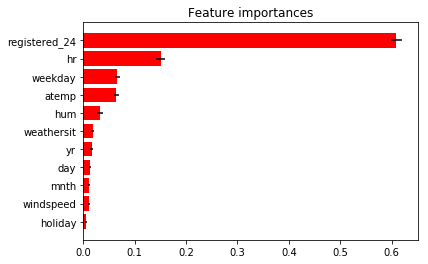

[8, 1, 10, 0, 5, 7, 6, 4, 2, 9]

In [124]:
def feature_importance(df, ratio = 0.01, plot = False):
    forest = RandomForestRegressor(n_estimators=100, random_state = SEED)
    acc, scores, forest = cv_evaluate(df, model = forest)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)
    
    if plot:
        X = df.loc[:, df.columns != TARGET_VARIABLE]
        print("Feature ranking:")
        plt.figure()
        plt.title("Feature importances")
        plt.barh(range(X.shape[1]), importances[indices],color="r", xerr=std[indices], align="center")
        plt.yticks(range(X.shape[1]), [list(df.loc[:, df.columns != TARGET_VARIABLE])[i] for i in indices])
        plt.ylim([-1, X.shape[1]])
        plt.show()
    
    
    keep = [x for x in indices if importances[x] > ratio]
    target = df.columns.get_loc(TARGET_VARIABLE)
    if target not in keep:
        keep.append(target)
        
    return keep

feature_importance(data, plot = True)

## Principal Component Analysis (PCA)
We will plot PCA component variance

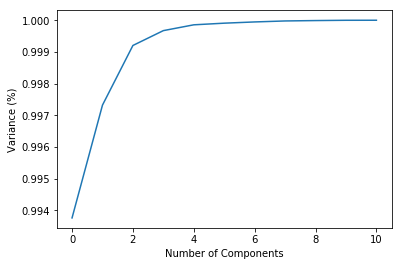

2

In [125]:
def plot_pca_components(df, variance = 0.9):
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    pca = PCA()
    X = pca.fit_transform(X)
    pca = PCA().fit(X)

    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.show()
    
    count = 0
    
    for ind, i in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if count < variance:
            count += i
        else:
            return ind + 1
        
plot_pca_components(data)

## Pipeline Function
The pipeline will decide which functions to keep and which not to based on if they improve the score

In [126]:
def feature_engineering_pipeline(df, transformers):
    selected_transformers = []
    
    base_score, scores, models = cv_evaluate(df)
    all_scores  = pd.DataFrame(columns = ['Function', 'CV Score', 'Holdout Score', 'Difference', 'Outcome'])
    all_scores = all_scores.append({'Function':'base_score','CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': base_score, 'Difference': 0, 'Outcome': 'Base'}, ignore_index=True)
    
    engineered_data = df.copy()
                                    
    for transformer in transformers:
        outcome = 'Rejected'
        
        new_score, scores, model = cv_evaluate(engineered_data, transformers = [transformer[1]])

        difference = (new_score - base_score)
                         
        if difference > 0.005:
            selected_transformers.append(transformer[1])
            base_score = new_score
            outcome = 'Accepted'

        score = { 'Function':transformer[0],'CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': new_score, 'Difference': difference, 'Outcome': outcome}
        
        all_scores = all_scores.append(score, ignore_index=True)
            
    return selected_transformers, all_scores

## Running the Pipeline
Here we will run the pipeline

In [127]:
transformers = [
    ('rfe', RFE(RandomForestRegressor(n_estimators=10, random_state = SEED))),
    ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state = SEED), threshold = 0.01)),
    ('binning', KBinsDiscretizer(n_bins=5, encode='onehot')),
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(.95))
]

final_transformers, all_scores = feature_engineering_pipeline(data, transformers)

if len(final_transformers) > 0:
    holdout_score, scores, model = cv_evaluate(data, splits = SPLITS, transformers = final_transformers)
else:
    holdout_score, scores, model = cv_evaluate(data, splits = SPLITS)
score = { 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])), 'Holdout Score': "{0:.3f}".format(holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
all_scores = all_scores.append(score, ignore_index=True)

## Scores
Here you can see all of the scores

In [128]:
all_scores

,Function,CV Score,Holdout Score,Difference,Outcome
0,base_score,0.71 +/- 0.021,0.712444,0,Base
1,rfe,0.70 +/- 0.021,0.706489,-0.00595556,Rejected
2,feature_selection,0.71 +/- 0.021,0.712442,-1.8159e-06,Rejected
3,binning,0.66 +/- 0.016,0.673228,-0.039216,Rejected
4,polynomial,0.76 +/- 0.015,0.765817,0.0533726,Accepted
5,pca,0.64 +/- 0.026,0.652079,-0.113738,Rejected
6,cross_evaluate,0.759 +/- 0.0058,0.766,0,Final Cross Validation


In [129]:
#This should be uncommented when you run GridSearch
#final_model = model.best_estimator_
#model.best_params_

#This should be removed after
final_model = model

# Final Score
This is the final score of the model

In [131]:
X_train = data.loc[:, data.columns != TARGET_VARIABLE]
y_train = data.loc[:, TARGET_VARIABLE]
final_model.fit(X_train, y_train)
X = holdout.loc[:, holdout.columns != TARGET_VARIABLE]
y = holdout.loc[:, TARGET_VARIABLE]
pred = final_model.predict(X)
score = metric_scorer(y,pred)
print(score)

0.6958407579018022


## Plot of Predictions

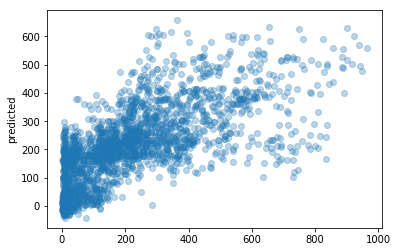

In [28]:
plt.scatter(y, pred, alpha=0.3)
plt.ylabel('predicted')
plt.show()

# To Do
* Run data through pipeline
* Fix cross validation/holdout testing, currently doing it with data with outliers removed for example
* Consider more feature creation steps
    * Segregate Outliers (downwards/upwards)
    * Create own weather metric

* Add boolean that its either weekend or weekday
* Decide when to convert variables to category, should we normalize before?
* Try dropping Atemp instead of temp
* Fix final score
* Fix GridSearch
* Consider more models + ensemble models
* Consider other data sources (events, sunrise/sundown)
* More plots
* Try not dropping some columns (correlated for example)
* Check values per category (ex: 30th february)
* Time series plot